<a href="https://colab.research.google.com/github/Jessicashenone/dissertation/blob/main/sentiment_analysis_dissertation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("/content/beforesentall.csv")

In [ ]:
target_column = 'translated_comment'

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1783 entries, 0 to 1782
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   video_id            1783 non-null   object
 1   video_title         1783 non-null   object
 2   comment             1783 non-null   object
 3   like_count          1783 non-null   int64 
 4   published_at        1783 non-null   object
 5   comment_len         1783 non-null   int64 
 6   language            1783 non-null   object
 7   translated_comment  1783 non-null   object
dtypes: int64(2), object(6)
memory usage: 111.6+ KB


In [ ]:
# Randomly sample 200 rows
df_pretest = df[['translated_comment']].sample(n=200, random_state=42)

# Save as CSV
output_file = "/content/pretset_comments.xlsx"
df_pretest.to_excel(output_file, index=False)

In [ ]:
df_manualpretest = pd.read_excel("/content/manualpretset_comments.xlsx")

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

# Sentiment scoring with VADER
Result = { 'compound':[], 'pos':[] , 'neu':[], 'neg':[] }
for review in df_manualpretest[target_column]:
    score = sid.polarity_scores(str(review))
    Result['pos'].append(score['pos'])
    Result['neu'].append(score['neu'])
    Result['neg'].append(score['neg'])
    Result['compound'].append(score['compound'])

df_manualpretest[['compound','pos','neu','neg']] = pd.DataFrame(Result)

# Map compound score into labels
df_manualpretest['vader_label'] = df_manualpretest['compound'].apply(
    lambda c: 2 if c >= 0.05 else (0 if c <= -0.05 else 1)
)


Accuracy: 0.57

Classification Report:
              precision    recall  f1-score   support

    Negative      0.633     0.452     0.528        42
     Neutral      0.567     0.430     0.489        79
    Positive      0.564     0.785     0.656        79

    accuracy                          0.575       200
   macro avg      0.588     0.556     0.558       200
weighted avg      0.579     0.575     0.563       200



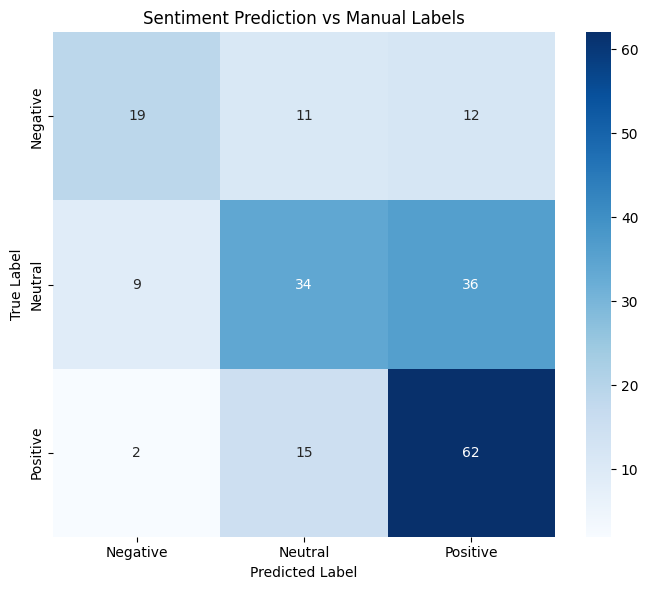

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Prepare true labels and predicted labels
y_true = df_manualpretest['manual_label']
y_pred = df_manualpretest['vader_label']

# Calculate accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.2f}")

# Print classification report with readable class names
target_names = ['Negative', 'Neutral', 'Positive']
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names, digits=3))

# Build confusion matrix with fixed label order
labels = [0, 1, 2]
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Plot heatmap that matches the shown style
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title("Sentiment Prediction vs Manual Labels")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [ ]:
df_ro_pretest = pd.read_excel("/content/manualpretset_comments.xlsx")

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Map labels to 0 1 2
label_map = {"LABEL_0": 0, "LABEL_1": 1, "LABEL_2": 2}

# Run prediction
pred_labels = []
for text in df_ro_pretest['translated_comment']:
    result = classifier(str(text))[0]
    pred_labels.append(label_map[result['label']])

df_ro_pretest['roberta_label'] = pred_labels


Accuracy: 71.00%

Classification Report:
              precision    recall  f1-score   support

    Negative       0.72      0.74      0.73        42
     Neutral       0.72      0.52      0.60        79
    Positive       0.70      0.89      0.78        79

    accuracy                           0.71       200
   macro avg       0.71      0.71      0.70       200
weighted avg       0.71      0.71      0.70       200



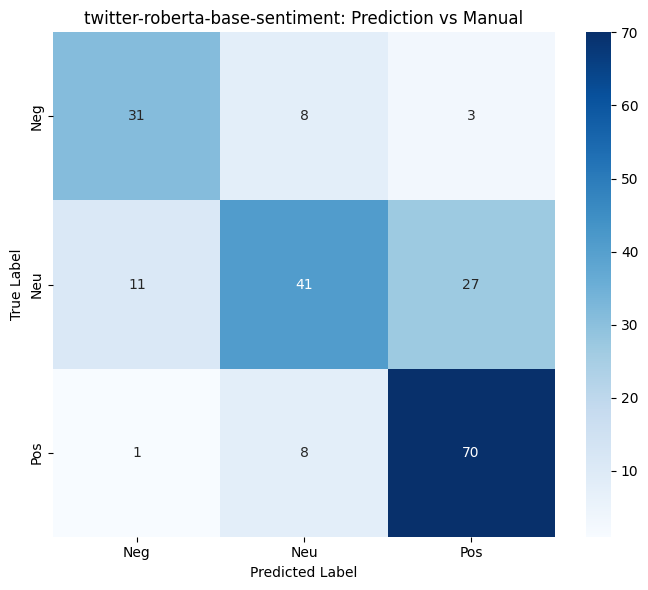

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Prepare true labels and predicted labels
y_true = df_ro_pretest['manual_label']
y_pred = df_ro_pretest['roberta_label']

# Print accuracy and classification report
acc = accuracy_score(y_true, y_pred)
print("Accuracy: {:.2f}%".format(acc * 100))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

# Build confusion matrix with fixed label order
labels = [0, 1, 2]
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Plot heatmap
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Neg", "Neu", "Pos"], yticklabels=["Neg", "Neu", "Pos"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("twitter-roberta-base-sentiment: Prediction vs Manual")
plt.tight_layout()
plt.show()


FINE TUNING

In [ ]:
df_soft_label = pd.read_csv("/content/beforesentall.csv")

#Load the pre-trained model
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)


from transformers import TextClassificationPipeline

classifier = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    device=-1,
    truncation=True,
    max_length=512,
    return_all_scores=False
)

#predict sentiment
pred_labels = []
pred_scores = []

for text in df_soft_label['translated_comment']:
    if isinstance(text, str) and text.strip():
        result = classifier(text.strip())[0]
        label = result['label']
        score = result['score']
        pred_labels.append(label)
        pred_scores.append(score)
    else:
        pred_labels.append("LABEL_UNKNOWN")
        pred_scores.append(0)

# Add results to DataFrame
df_soft_label['roberta_label'] = pred_labels
df_soft_label['roberta_score'] = pred_scores

df_soft_label.head()

Device set to use cpu
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


,video_id,video_title,comment,like_count,published_at,comment_len,language,translated_comment,roberta_label,roberta_score
0,-78WBnpqJUw,Too official to ever need validating but we pr...,You go Gurl! ❤❤❤,9,2025-03-11T08:24:21Z,4,cy,you go gurl! ❤❤❤,LABEL_2,0.976330
1,-78WBnpqJUw,Too official to ever need validating but we pr...,i bet she’s a really good hip hop artist but s...,5,2025-03-10T20:44:15Z,29,en,i bet she is a really good hip hop artist but ...,LABEL_1,0.567302
2,-78WBnpqJUw,Too official to ever need validating but we pr...,Hol up hol up Doechii got a Nike deal?!?!? Ins...,31,2025-03-10T20:35:51Z,16,en,hol up hol up doechii got a nike deal?!?!? ins...,LABEL_1,0.596320
3,17aYq81IENc,Morning | Nike,esse anúncio é bom demais,2,2025-03-14T18:16:06Z,5,pt,this ad is too good,LABEL_2,0.982855
4,17aYq81IENc,Morning | Nike,What's the song name ?,2,2025-01-19T02:38:28Z,5,en,what is the song name ?,LABEL_1,0.868364


In [ ]:
numeric_map = {
    'LABEL_0': 0,
    'LABEL_1': 1,
    'LABEL_2': 2
}
df_soft_label['label_num'] = df_soft_label['roberta_label'].map(numeric_map)
df_soft_label

,video_id,video_title,comment,like_count,published_at,comment_len,language,translated_comment,roberta_label,roberta_score,label_num
0,-78WBnpqJUw,Too official to ever need validating but we pr...,You go Gurl! ❤❤❤,9,2025-03-11T08:24:21Z,4,cy,you go gurl! ❤❤❤,LABEL_2,0.976330,2
1,-78WBnpqJUw,Too official to ever need validating but we pr...,i bet she’s a really good hip hop artist but s...,5,2025-03-10T20:44:15Z,29,en,i bet she is a really good hip hop artist but ...,LABEL_1,0.567302,1
2,-78WBnpqJUw,Too official to ever need validating but we pr...,Hol up hol up Doechii got a Nike deal?!?!? Ins...,31,2025-03-10T20:35:51Z,16,en,hol up hol up doechii got a nike deal?!?!? ins...,LABEL_1,0.596320,1
3,17aYq81IENc,Morning | Nike,esse anúncio é bom demais,2,2025-03-14T18:16:06Z,5,pt,this ad is too good,LABEL_2,0.982855,2
4,17aYq81IENc,Morning | Nike,What's the song name ?,2,2025-01-19T02:38:28Z,5,en,what is the song name ?,LABEL_1,0.868364,1
...,...,...,...,...,...,...,...,...,...,...,...
1778,ylco2-nUSeM,WINNING ISN’T FOR EVERYONE | REGRETS | LEBRON,What happened in 2004?🇦🇷🇦🇷🇦🇷,23,2024-08-10T20:47:11Z,4,en,what happened in 2004?🇦🇷🇦🇷🇦🇷,LABEL_1,0.662926,1
1779,ylco2-nUSeM,WINNING ISN’T FOR EVERYONE | REGRETS | LEBRON,He’s still thinking about LeBronze,13,2024-08-10T13:52:56Z,5,en,he is still thinking about lebronze,LABEL_1,0.833210,1
1780,ylco2-nUSeM,WINNING ISN’T FOR EVERYONE | REGRETS | LEBRON,you are my sunshine,7,2024-08-10T11:07:47Z,4,en,you are my sunshine,LABEL_2,0.931171,2
1781,ylco2-nUSeM,WINNING ISN’T FOR EVERYONE | REGRETS | LEBRON,You are my sunshine...,8,2024-08-10T11:01:14Z,4,en,you are my sunshine...,LABEL_2,0.926704,2


In [ ]:
df_soft_label.to_excel("allsoftlabels.xlsx", index=False)

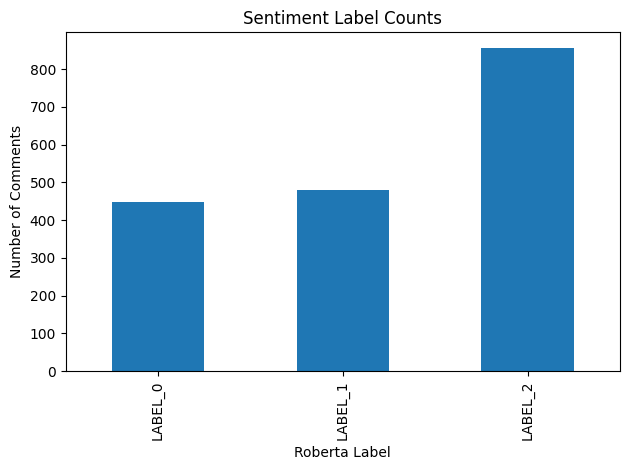

In [ ]:
import matplotlib.pyplot as plt

label_order = ['LABEL_0', 'LABEL_1', 'LABEL_2']
label_counts = df_soft_label['roberta_label'].value_counts().reindex(label_order)

plt.figure()
label_counts.plot(kind='bar')
plt.title('Sentiment Label Counts')
plt.xlabel('Roberta Label')
plt.ylabel('Number of Comments')
plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

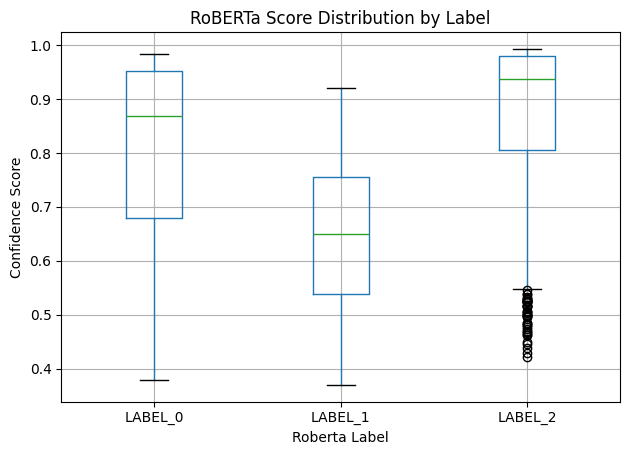

In [ ]:
plt.figure()
df_soft_label.boxplot(column='roberta_score', by='roberta_label')
plt.title('RoBERTa Score Distribution by Label')
plt.suptitle('')  # remove the auto-generated subtitle
plt.xlabel('Roberta Label')
plt.ylabel('Confidence Score')
plt.tight_layout()
plt.show()

In [ ]:
# Filter low-confidence
low_conf = df_soft_label[df_soft_label['roberta_score'] < 0.7]

# Sample label
sample_0 = low_conf[low_conf['roberta_label']=='LABEL_0'].sample(n=60, random_state=42)
sample_1 = low_conf[low_conf['roberta_label']=='LABEL_1'].sample(n=70, random_state=42)
sample_2 = low_conf[low_conf['roberta_label']=='LABEL_2'].sample(n=70, random_state=42)

# Combine into annotation pool
annotation_pool = pd.concat([sample_0, sample_1, sample_2]).reset_index(drop=True)

# Verify sizes
print(annotation_pool['roberta_label'].value_counts())


roberta_label
LABEL_1    70
LABEL_2    70
LABEL_0    60
Name: count, dtype: int64


In [ ]:
annotation_pool.head()

,video_id,video_title,comment,like_count,published_at,comment_len,language,translated_comment,roberta_label,roberta_score,label_num
0,_Ra6wkIoJp0,WINNING ISN’T FOR EVERYONE | AGAIN | LEBRON JA...,Why isn’t there a tee out yet? I WANT a tee wi...,4,2024-08-03T16:34:50Z,15,en,why is not there a tee out yet? i want a tee w...,LABEL_0,0.587545,0
1,b0Ezn5pZE7o,So Win. | Nike,You can’t address the most important issue in ...,4,2025-03-07T01:37:14Z,29,en,you cannot address the most important issue in...,LABEL_0,0.579448,0
2,Al3h1DXwwRA,We All Need Someone To Make Us Believe | adidas,If you are earning to this add💩💩💩,1,2025-04-17T06:01:16Z,7,en,if you are earning to this add💩💩💩,LABEL_0,0.542806,0
3,b0Ezn5pZE7o,So Win. | Nike,❤ To EVERYONE who said something bad about thi...,3,2025-02-13T16:22:47Z,26,en,❤ to everyone who said something bad about thi...,LABEL_0,0.531329,0
4,LaI7Ty0UeRk,PUMA. GO WILD.,"Compré Puma, pisé mierda, Quedó la cagá, quedó...",18,2025-04-02T19:53:07Z,13,es,"i bought puma, i stepped on shit, the cagá was...",LABEL_0,0.673566,0


In [ ]:
annotation_pool = annotation_pool.sample(frac=1, random_state=42).reset_index(drop=True)

print(annotation_pool['roberta_label'].value_counts())
annotation_pool.head(10)

roberta_label
LABEL_1    70
LABEL_2    70
LABEL_0    60
Name: count, dtype: int64


,video_id,video_title,comment,like_count,published_at,comment_len,language,translated_comment,roberta_label,roberta_score,label_num
0,32__plJ-Q_Y,Summer of Sport Anthem Film | adidas,Like this brand amizing,1,2024-08-24T05:32:06Z,4,en,like this brand amizing,LABEL_1,0.604838,1
1,qQ7SPeNyoH4,You’re already late to the future. #Nike,JuJu gonna be a problem in the league!,2,2025-02-28T18:34:36Z,8,en,juju going to be a problem in the league!,LABEL_0,0.460334,0
2,LaI7Ty0UeRk,PUMA. GO WILD.,This ad makes me want weed and I don't even smoke,17,2025-04-06T17:38:08Z,11,en,this ad makes me want weed and i do not even s...,LABEL_0,0.526532,0
3,RTHSw0bJjdU,WINNING ISN’T FOR EVERYONE | KOBE BRYANT | NIKE,Black Mamba forever\n\nRIP Kobe forever my idol,206,2024-07-18T14:08:14Z,8,da,black mamba forever rip kobe forever my idol,LABEL_2,0.682216,2
4,jLDh-dbosRE,The Only Way Is Through: Cynthia Lozada,Under armour needs to expand to nature. Hiking...,2,2020-03-24T03:22:35Z,13,en,under armour needs to expand to nature. hiking...,LABEL_1,0.629380,1
5,JfK0mHEy0po,Joy | Nike,All pain. All gain. (:,81,2024-09-11T00:48:19Z,5,cy,all pain. all gain. (:,LABEL_1,0.587351,1
6,a6382QsPros,The Giant Tennis Court Challenge With Felix & ...,"Hello Adidas, I am a kid from Morocco who play...",2,2024-03-07T23:45:21Z,26,en,"hello adidas, i am a kid from morocco who play...",LABEL_1,0.428417,1
7,RTHSw0bJjdU,WINNING ISN’T FOR EVERYONE | KOBE BRYANT | NIKE,That was his most vicious mamba look EVER to m...,19,2024-11-01T04:27:39Z,29,en,that was his most vicious mamba look ever to m...,LABEL_2,0.685595,2
8,Y_GVqaZ0uvE,"Anthony Edwards, By His Best Friend Nick Maddox",A Global Icon,9,2025-04-19T19:36:46Z,3,it,a global icon,LABEL_2,0.574855,2
9,pwLergHG81c,WINNING ISN’T FOR EVERYONE | AM I A BAD PERSON...,As a United States Marine :: \n\nNot even we a...,14,2024-08-01T00:05:39Z,14,en,as a united states marine :: not even we are t...,LABEL_0,0.461636,0


In [ ]:
annotation_pool.to_excel("annotation_pool.xlsx", index=False)

In [ ]:
#load data
df_low = pd.read_excel("/content/annotationed_pool.xlsx")
df_all = pd.read_excel("/content/allsoftlabels.xlsx")

#high-confidence pool (pseudo labels > 0.9)
high_conf = df_all[df_all["roberta_score"] > 0.9].copy()

#A: manual set
A = df_low[["translated_comment", "manual_label"]].rename(
    columns={"manual_label": "label"}
)

#P: pseudo set
n = min(len(A), len(high_conf))
P = high_conf.sample(n=n, random_state=42)[
    ["translated_comment", "roberta_label"]
].rename(columns={"roberta_label": "label"})




In [ ]:
A.head()

,translated_comment,label
0,like this brand amizing,2
1,juju going to be a problem in the league!,0
2,this ad makes me want weed and i do not even s...,1
3,black mamba forever rip kobe forever my idol,2
4,under armour needs to expand to nature. hiking...,1


In [ ]:
P.head()

,translated_comment,label
1271,congratulations on everything sis!❤️❤️,LABEL_2
71,now that got me hyped! great job adidas!,LABEL_2
578,a complete of music and marketing ... i will n...,LABEL_0
444,excellent,LABEL_2
437,i love it,LABEL_2


In [ ]:
P['label'] = (
    P['label']
    .astype(str)                    # ensure everything is string
    .str.replace(r'^LABEL_', '', regex=True)
    .astype(int)                    # convert '0','1','2' to integers
)

# 2) Verify
print(P['label'].dtype)      # should be int64
print(P['label'].unique())   # should be [0,1,2]

int64
[2 0 1]


In [ ]:
P.head()

,translated_comment,label
1271,congratulations on everything sis!❤️❤️,2
71,now that got me hyped! great job adidas!,2
578,a complete of music and marketing ... i will n...,0
444,excellent,2
437,i love it,2


In [ ]:
# Setup
import os, torch, numpy as np, pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer)

#disable online logging
os.environ["WANDB_DISABLED"] = "true"           # disable wandb
os.environ["HF_HUB_DISABLE_TELEMETRY"] = "1"   #
os.environ["CUDA_VISIBLE_DEVICES"] = "0"       # force use GPU:0 (Colab T4)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE, "| GPU:", torch.cuda.get_device_name(0))

MODEL = "cardiffnlp/twitter-roberta-base-sentiment"

#merge manual + pseudo
D = pd.concat([A, P], ignore_index=True)

# stratified 5-fold by label
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
splits = list(skf.split(np.zeros(len(D)), D["label"]))

Device: cuda:0 | GPU: Tesla T4


In [ ]:
# tokenizer/dataset/metrics
tok = AutoTokenizer.from_pretrained(MODEL)

def enc(df):
    e = tok(list(df.translated_comment), truncation=True, padding=True, max_length=160)
    e["labels"] = [int(x) for x in df.label]
    return e

class DS(torch.utils.data.Dataset):
    def __init__(self, e): self.e=e
    def __len__(self): return len(self.e["input_ids"])
    def __getitem__(self,i): return {k: torch.tensor(v[i], dtype=torch.long) for k,v in self.e.items()}

def metrics(pred):
    lg, y = pred
    pr = np.argmax(lg,1)
    a = accuracy_score(y, pr)
    p,r,f1,_ = precision_recall_fscore_support(y, pr, average="macro", zero_division=0)
    return {"eval_accuracy":a,"eval_precision":p,"eval_recall":r,"eval_f1":f1}


In [ ]:
# training with early stop on F1
LR, WEIGHT_DECAY = 1e-5, 0.01
TRAIN_BS, EVAL_BS = 32, 64
WARMUP_RATIO = 0.06
MAX_EPOCHS, PATIENCE, MIN_IMPROVE = 8, 2, 2e-2

def run_fold(train_df, valid_df, fold):
    tr, va = DS(enc(train_df)), DS(enc(valid_df))
    model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=3).to(DEVICE)

    args = TrainingArguments(
        output_dir=f"./out_fold{fold}",
        learning_rate=LR, weight_decay=WEIGHT_DECAY,
        per_device_train_batch_size=TRAIN_BS,
        per_device_eval_batch_size=EVAL_BS,
        num_train_epochs=1,  # manual loop
        logging_steps=10,
        seed=42, fp16=True,
        report_to=[]
    )
    trainer = Trainer(model=model, args=args, train_dataset=tr, eval_dataset=va,
                      tokenizer=tok, compute_metrics=metrics)
    trainer.model.to(DEVICE)

    best_f1, bad = float("-inf"), 0
    for ep in range(1, MAX_EPOCHS + 1):
        trainer.train()
        tloss = [x["loss"] for x in trainer.state.log_history if "loss" in x][-1]
        m = trainer.evaluate()
        f1 = m["eval_f1"]
        print(f"[fold {fold}] epoch {ep} | loss={tloss:.4f} F1={f1:.4f}")

        # improvement if F1 increases by at least MIN_IMPROVE
        if f1 - best_f1 >= MIN_IMPROVE:
            best_f1, bad = f1, 0
        else:
            bad += 1
            if bad >= PATIENCE:
                print(f"[fold {fold}] early stopped at epoch {ep} (no F1 improvement)")
                break

    return trainer.evaluate()


In [ ]:
# run 5 folds & summary
fold_metrics = []
for k,(tri,vai) in enumerate(splits,1):
    fold_metrics.append(run_fold(D.iloc[tri], D.iloc[vai], k))

keys = ["eval_accuracy","eval_precision","eval_recall","eval_f1"]
cv_mean = {k: float(np.mean([m[k] for m in fold_metrics])) for k in keys}
cv_std  = {k: float(np.std([m[k] for m in fold_metrics]))  for k in keys}
print("\nCV mean:", cv_mean)
print("CV  std :", cv_std)

In [ ]:
import os, torch, numpy as np, pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

#gpu
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["WANDB_DISABLED"] = "true"
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# constants identical to 5-fold
LR, WEIGHT_DECAY = 1e-5, 0.01
TRAIN_BS, EVAL_BS = 32, 64
WARMUP_RATIO = 0.06
MAX_EPOCHS, PATIENCE, MIN_IMPROVE = 8, 2, 2e-2
LOGGING_STEPS = 10

# merge manual and pseudo
A_ = A.copy(); A_["src"] = "A"
P_ = P.copy(); P_["src"] = "P"
D_final = pd.concat([A_, P_], ignore_index=True)

#tokenizer
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tok = AutoTokenizer.from_pretrained(MODEL)

def enc(df: pd.DataFrame):
    e = tok(list(df.translated_comment), truncation=True, padding=True, max_length=160)
    e["labels"] = [int(x) for x in df.label]
    return e

class DS(torch.utils.data.Dataset):
    def __init__(self, e): self.e=e
    def __len__(self): return len(self.e["input_ids"])
    def __getitem__(self, i): return {k: torch.tensor(v[i], dtype=torch.long) for k, v in self.e.items()}

#cut a 20% test set
strata = (D_final["src"].astype(str) + "_" + D_final["label"].astype(int).astype(str)).values
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
train_idx, test_idx = next(sss.split(D_final, strata))
train_df = D_final.iloc[train_idx].reset_index(drop=True)
test_df   = D_final.iloc[test_idx].reset_index(drop=True)

train_ds = DS(enc(train_df))
test_ds   = DS(enc(test_df))

# F1 metrix
def metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="macro", zero_division=0)
    acc = accuracy_score(labels, preds)
    return {"eval_accuracy": acc, "eval_precision": p, "eval_recall": r, "eval_f1": f1}

# ==== model ====
model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=3).to(DEVICE)

# ==== training args ====
args = TrainingArguments(
    output_dir="./final_model",
    learning_rate=LR, weight_decay=WEIGHT_DECAY,
    per_device_train_batch_size=TRAIN_BS,
    per_device_eval_batch_size=EVAL_BS,
    num_train_epochs=1,             # manual loop
    warmup_ratio=WARMUP_RATIO,
    logging_steps=LOGGING_STEPS,
    seed=42, fp16=True,
    report_to=[]
)

#trainer
trainer = Trainer(
    model=model, args=args,
    train_dataset=train_ds, eval_dataset=test_ds,
    tokenizer=tok, compute_metrics=metrics
)
trainer.model.to(DEVICE)

#early stop on f1
best_f1, bad = float("-inf"), 0
for ep in range(1, MAX_EPOCHS + 1):
    trainer.train()
    tloss = [x["loss"] for x in trainer.state.log_history if "loss" in x][-1]
    m = trainer.evaluate()
    f1 = m["eval_f1"]
    print(f"epoch {ep} | train_loss {tloss:.4f} | F1(dev) {f1:.4f}")
    if f1 - best_f1 >= MIN_IMPROVE:
        best_f1, bad = f1, 0
    else:
        bad += 1
        if bad >= PATIENCE:
            print(f"early stopped at epoch {ep} (no F1 improvement on dev)")
            break

#save model
trainer.save_model("./final_model")
tok.save_pretrained("./final_model")

#apply to all comments
df_all = pd.read_csv("/content/beforesentall.csv")
test_enc = tok(list(df_all.translated_comment), truncation=True, padding=True, max_length=160, return_tensors="pt").to(DEVICE)
with torch.no_grad():
    out = model(**test_enc)
    probs = torch.softmax(out.logits, dim=-1).cpu().numpy()
    preds = np.argmax(probs, axis=1)

df_all["pred_label"] = preds
df_all["prob_neg"] = probs[:, 0]
df_all["prob_neu"] = probs[:, 1]
df_all["prob_pos"] = probs[:, 2]

df_all.head()


In [ ]:
# save predictions
df_all.to_csv("final_sentiment.csv", index=False)

In [ ]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1783 entries, 0 to 1782
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   video_id            1783 non-null   object 
 1   video_title         1783 non-null   object 
 2   comment             1783 non-null   object 
 3   like_count          1783 non-null   int64  
 4   published_at        1783 non-null   object 
 5   comment_len         1783 non-null   int64  
 6   language            1783 non-null   object 
 7   translated_comment  1783 non-null   object 
 8   pred_label          1783 non-null   int64  
 9   prob_neg            1783 non-null   float32
 10  prob_neu            1783 non-null   float32
 11  prob_pos            1783 non-null   float32
dtypes: float32(3), int64(3), object(6)
memory usage: 146.4+ KB


In [ ]:
df_senti = pd.read_csv("/content/final_sentiment.csv")

Sentiment distribution:
sentiment
negative    453
neutral     413
positive    917
Name: count, dtype: int64


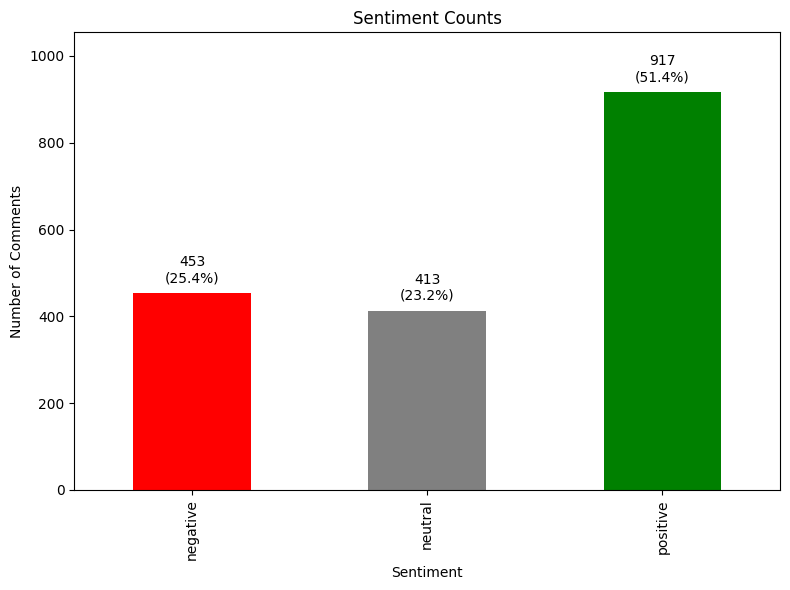

In [ ]:
# Map LABEL_0/1/2 to negative/neutral/positive
label_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
df_senti['sentiment'] = df_senti['pred_label'].map(label_map)

# Count and order
order = ['negative', 'neutral', 'positive']
counts = df_senti['sentiment'].value_counts().reindex(order)

print("Sentiment distribution:")
print(counts)

# Plot
plt.figure(figsize=(8,6))
ax = counts.plot(kind='bar', color=['red', 'gray', 'green'])

# Title and labels
plt.title('Sentiment Counts')
plt.xlabel('Sentiment')
plt.ylabel('Number of Comments')


total = counts.sum()
for i, v in enumerate(counts):
    if v > 0:
        pct = f"{v/total:.1%}"
        plt.text(i, v + total*0.01, f"{v}\n({pct})", ha='center', va='bottom')

ymax = counts.max()
plt.ylim(0, ymax * 1.15)

plt.tight_layout()
plt.show()



           count       mean         std  min  25%  50%   75%     max
sentiment                                                           
negative   453.0  40.339956  105.357836  1.0  3.0  5.0  23.0   859.0
neutral    413.0  74.375303  486.959306  1.0  2.0  4.0  14.0  8187.0
positive   917.0  38.044711  176.333445  1.0  3.0  6.0  19.0  3822.0


<Figure size 600x400 with 0 Axes>

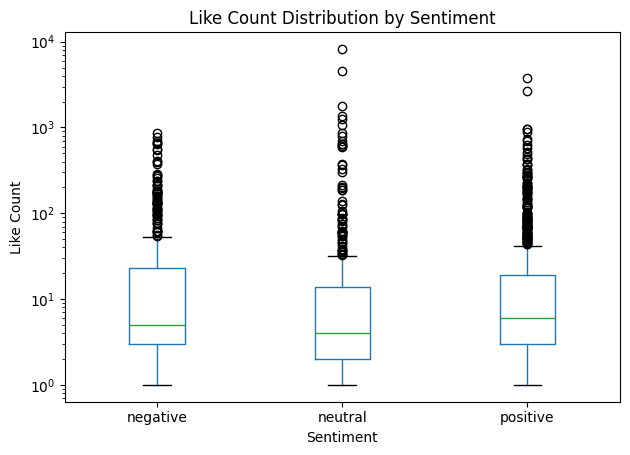

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

stats = df_senti.groupby('sentiment')['like_count'].describe()
print(stats)


plt.figure(figsize=(6,4))
df_senti.boxplot(
    column='like_count',
    by='sentiment',
    grid=False,
    showfliers=True,
    vert=True,
)
plt.suptitle('')
plt.title('Like Count Distribution by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Like Count')
plt.yscale('log')
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from scipy.stats import chisquare
import math

#counts from chart
observed = np.array([453, 413, 917])

# expected counts
total = observed.sum()
expected = np.array([total/3, total/3, total/3])

# chi-square goodness-of-fit test
chi2, p = chisquare(f_obs=observed, f_exp=expected)

# effect size (Cohen's w)
w = math.sqrt(chi2 / total)

print("Chi-square =", chi2)
print("p-value =", p)
print("Cohen's w =", w)


Chi-square = 264.1121704991587
p-value = 4.454211905160148e-58
Cohen's w = 0.38487396637590293


H2

In [ ]:
import scipy.stats as stats
#Group data by sentiment
groups = [df_senti[df_senti["pred_label"] == cat]["like_count"].values
          for cat in df_senti["pred_label"].unique()]

#Kruskal–Wallis H test
H, p = stats.kruskal(*groups)
print(f"Kruskal-Wallis H = {H:.4f}, p-value = {p:.4f}")

#Effect size
N = 1783
k = 3
eta2 = (H - k + 1) / (N - k)
print(f"Effect size (η²) = {eta2:.4f}")

Kruskal-Wallis H = 17.5733, p-value = 0.0002
Effect size (η²) = 0.0087


In [ ]:
import pandas as pd

# calculate max_prob
df_senti["max_prob"] = df_senti[["prob_neg","prob_neu","prob_pos"]].max(axis=1)

# base distribution
base_props = df_senti["pred_label"].value_counts(normalize=True)

# high confidence pool
pool = df_senti[df_senti["max_prob"] >= 0.7]
N_sub = len(pool)

# stratified top-N by base proportions
df_sub = pd.concat([
    pool[pool["pred_label"] == c]
    .sort_values("max_prob", ascending=False)
    .head(int(round(base_props[c] * N_sub)))
    for c in base_props.index
])


In [ ]:
print("Subset size =", len(df_sub))
print(df_sub["pred_label"].value_counts())

Subset size = 1587
pred_label
2    842
0    416
1    329
Name: count, dtype: int64


In [ ]:
#counts from chart
observed = np.array([416, 329, 842])

# expected counts
total = observed.sum()
expected = np.array([total/3, total/3, total/3])

# chi-square goodness-of-fit test
chi2, p = chisquare(f_obs=observed, f_exp=expected)

# effect size (Cohen's w)
w = math.sqrt(chi2 / total)

print("Chi-square =", chi2)
print("p-value =", p)
print("Cohen's w =", w)

Chi-square = 284.94896030245746
p-value = 1.330820426925249e-62
Cohen's w = 0.42373571936163484


In [ ]:
import scipy.stats as stats # Import the scipy.stats module

groups = [df_sub[df_sub["pred_label"] == c]["like_count"].values for c in CLASS_ORDER]

H, p = stats.kruskal(*groups) # Call kruskal from the imported stats module
N = len(df_sub)
k = 3
eta2 = (H - k + 1) / (N - k) if N > k else np.nan

print("H2 H =", H)
print("H2 p =", p)
print("H2 eta2 =", eta2)

H2 H = 23.937610792675546
H2 p = 6.338899428280653e-06
H2 eta2 = 0.013849501763052744


robustness test2

In [ ]:
df_sentisort= df_senti.sort_values("like_count", ascending=False)


N10 = len(df_sentisort) // 2
df_top10 = df_sentisort.head(N10)

In [ ]:
print("Subset size =", len(df_top10))
print(df_top10["pred_label"].value_counts())

Subset size = 891
pred_label
2    502
0    207
1    182
Name: count, dtype: int64


In [ ]:
#counts from chart
observed = np.array([207, 182, 502])

# expected counts
total = observed.sum()
expected = np.array([total/3, total/3, total/3])

# chi-square goodness-of-fit test
chi2, p = chisquare(f_obs=observed, f_exp=expected)

# effect size (Cohen's w)
w = math.sqrt(chi2 / total)

print("Chi-square =", chi2)
print("p-value =", p)
print("Cohen's w =", w)

Chi-square = 213.2996632996633
p-value = 4.8146710294374115e-47
Cohen's w = 0.4892786133723303


In [ ]:
groups = [df_top10[df_top10["pred_label"] == cat]["like_count"].values
          for cat in df_top10["pred_label"].unique()]

#Kruskal–Wallis H test
H, p = stats.kruskal(*groups)
print(f"Kruskal-Wallis H = {H:.4f}, p-value = {p:.4f}")

#Effect size
N = 891
k = 3
eta2 = (H - k + 1) / (N - k)
print(f"Effect size (η²) = {eta2:.4f}")

Kruskal-Wallis H = 13.0188, p-value = 0.0015
Effect size (η²) = 0.0124
